# Team Homework 2 - MATH 420
## James Boggs and Camilo Velez R
### NYC Covid Data

In [1]:
# activate env and instantiate pkgs
using Pkg
Pkg.activate("../p1")
Pkg.instantiate()

  Activating project at `~/m420p1/p1`


In [2]:
using CSV, DataFrames, LaTeXStrings, Plots, Distances, JuMP, GLPK # import necessary pkgs

In [3]:
df = CSV.read("../resources/data.csv", DataFrame) # entire df

v_infected = values(df[1, 13:end]) # vector of infected numbers
infected_dates = names(df[1, 13:end]) # vector of infected_dates
@assert length(v_infected) == length(infected_dates)

# Exercise 1

## 1)

In [4]:
yd = values(df[2, 13:end]); 

In [5]:
v(t::Int)::Int = v_infected[t]
y(t::Int)::Int = yd[t];

In [6]:
findfirst([x>=5 for x in v_infected])

46

In [7]:
y_deaths = values(df[2, 13+46-1:end]); # vector of deaths

$T_{0} = 46$

In [8]:
function I(t::Int, τ::Int=7)::Real
    t0 = 46
    return v(t+t0+τ) - v(t+t0-τ)
end

I (generic function with 2 methods)

In [9]:
popu=df.Population[1];
tmax = 119;

In [10]:
# df = CSV.read("../resources/data.csv", DataFrame) # entire df

# read the values of infections and deaths from the table
infected = values(df[1, 13:end]) # vector of infected numbers
deaths = values(df[2, 13:end]) # vector of death numbers
infected_dates = names(df[1, 13:end]) # vector of infected_dates
population = df.Population[1];
@assert length(infected) == length(deaths)
# parameters
Vmin = 5
τ0 = 7
λ = 1

t0 = findfirst([x>=Vmin for x in infected])
tmax = 119
# define V, Y, and I for the range of times we are interested in
V(t) = infected[t + t0]
Y(t) = deaths[t + t0]
I(t) = infected[t + t0 + τ0] - infected[t + t0 - τ0]

I (generic function with 3 methods)

In [11]:
# function to find the optimal gamma for a given R_sim and p
@inline function optGammap2(R_sim::Vector{T}, yf::Function, tmax::Int=119)::Float64 where T<:Float64
    s1(t) = Y(t)*R_sim[t+1]
    s2(t) = abs(R_sim[t+1])^2
    gamma_c = sum(s1, 0:tmax)/sum(s2, 0:tmax)
    if gamma_c < 0 
        return 0.0
    elseif gamma_c > 1
        return 1.0
    else
        return gamma_c
    end
end

@inline function optGammapinf(R_sim::Vector{T}, yf::Function, tmax::Int=119)::Float64 where T<:Float64
    model = Model()
    set_optimizer(model, GLPK.Optimizer)
    
    @variable(model, x1>= 0)
    @variable(model, 1>=x2>=0)

    for t = 0:tmax
        @constraint(model, (-x1) - R_sim[t+1]*x2 <= -yf(t))
        @constraint(model, (-x1) + R_sim[t+1]*x2 <= yf(t))
    end

    @objective(model, Min, x1)
    optimize!(model)

    return value.(x2)
end

optGammapinf (generic function with 2 methods)

In [12]:
@inline function optGammap1(R_sim::Vector{T}, yf::Function, tmax::Int=119)::Float64 where T<:Float64
        r_vector = yf.(0:tmax)./R_sim
        filter!(!isinf, r_vector) # filter out r = x/0
        filter!(x -> x<=1, r_vector)
        filter!(x -> x>=0, r_vector)
        vf(r::Float64, tmax::Int=119)::Float64 = Cityblock()(Y.(0:tmax), r*R_sim)
        md = Dict{Float64, Float64}(r_vector .=> vf.(r_vector))
        
        return argmin(md)
    end

optGammap1 (generic function with 2 methods)

In [13]:
# Euler scheme
@inline function euler(alpha::Real, beta::Real, N::Real, to::Int=120; h::Real=0.01)::NTuple{3, Vector{Float64}}
  n = 2

  S_sim = Vector{Float64}(undef, to)
  I_sim = Vector{Float64}(undef, to)
  R_sim = Vector{Float64}(undef, to)

  s = N # introduce Ntotal = sum (sir)
  i = I(0)
  r = 0
  N_total = s + i + r

  t = 0

  S_sim[1] = s
  I_sim[1] = i
  R_sim[1] = r
  n = 2
  c_target = 1/h
  c_current = 2
  _n = 1
  while n <= to # pass as var, alternative counter 1/h
    ds = -beta*s*(i/N_total) # replace with Ntotal, same SEIR
    di = beta*s*(i/N_total) - alpha*i
    dr = alpha*i
  
    s += h*ds
    i += h*di
    r += h*dr
    N_total = s + i + r
    t += h
    if c_current == c_target
      S_sim[n] = s
      I_sim[n] = i
      R_sim[n] = r
      n += 1
      c_current = 0
    end
    c_current += 1
    _n +=1
  end

  return S_sim, I_sim, R_sim
end

euler (generic function with 2 methods)

In [14]:
Y1 = first(y_deaths, 120);

In [15]:
function J1(γ, Is, Rs, p)::Real # generic vars
    λ = 1
    f1(t) = abs(I(t) - Is[t+1])^p
    f2(t) = abs(y_deaths[t+1] - γ*Rs[t+1])^p
    return sum(f1, 0:119) + λ*sum(f2, 0:119)
end


J1 (generic function with 1 method)

## $p=1$

In [16]:
Jd = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [17]:

Threads.nthreads()

10

In [18]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
        Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N)
            γ̂  = optGammap1(Rs, Y)
            Jd[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 1)
        end
    end
end

In [19]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd)
J_min = Jd[argmin(Jd)];

In [20]:
display(L"\text{For}  p=1")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=1$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.17, 0.323, 1.9, 48861.18, 0.07909677731834515)


L"$J_{min}\approx 210876.271$"

In [21]:
48861.18/popu

0.03

### 2)

In [22]:
function Jplot(α, β, p)
    S, I, R = euler(α, β, N̂)
    return J1(γ̂, I, R, p)
end

Jplot (generic function with 1 method)

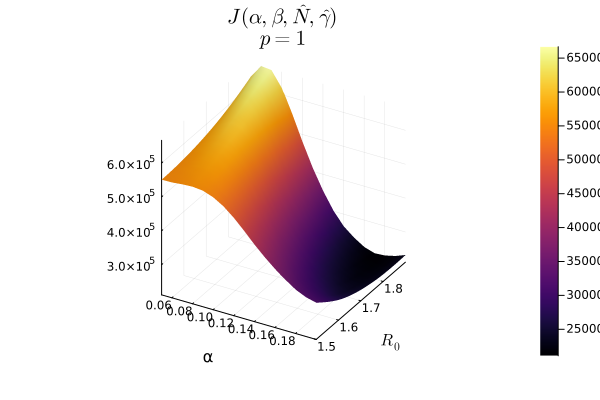

In [23]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot(x, x*y, 1), title=L"J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=1", xlabel="α", ylabel=L"R_{0}"))
png("p1surface_exercise1");

### 3)

In [24]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

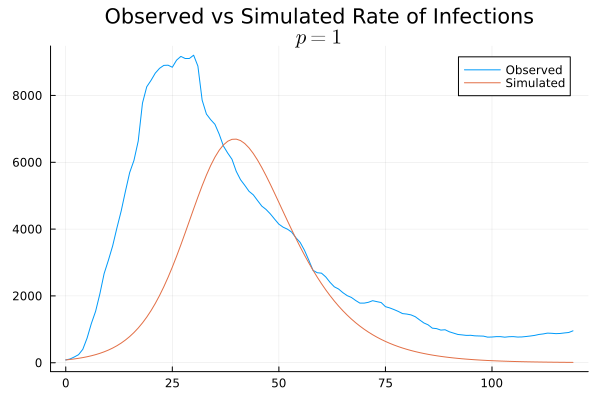

In [25]:
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "Observed vs Simulated Rate of Infections" * "\n" * L"p=1")

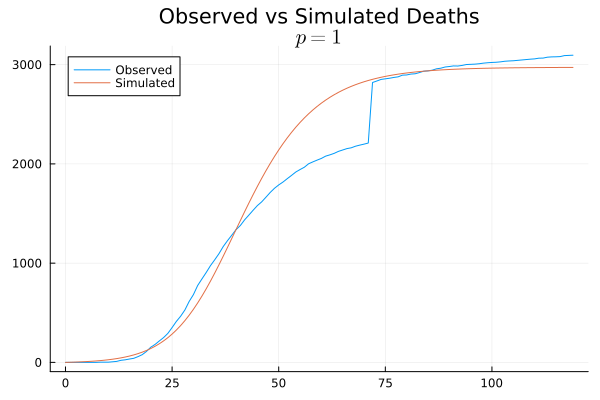

In [26]:
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "Observed vs Simulated Deaths" * "\n" * L"p=1")

Big increase from 5/17/2020 to 5/18/2020 (+610 deaths). Only possible explanation: NYC health department changed from releasing daily pdf to uploading their data to GitHub right on this date.

#### $p=2$

In [27]:
Jd = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [28]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
        Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N)
            γ̂  = optGammap2(Rs, Y)
            Jd[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 2)
        end
    end
end

In [29]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd)
J_min = Jd[argmin(Jd)];

In [30]:
display(L"\text{For}  p=2")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=2$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.2, 0.38, 1.9, 65148.24, 0.054092328587712436)


L"$J_{min}\approx 5.33628833613e8$"

In [31]:
65148/popu

0.039999852643755225

### 2)

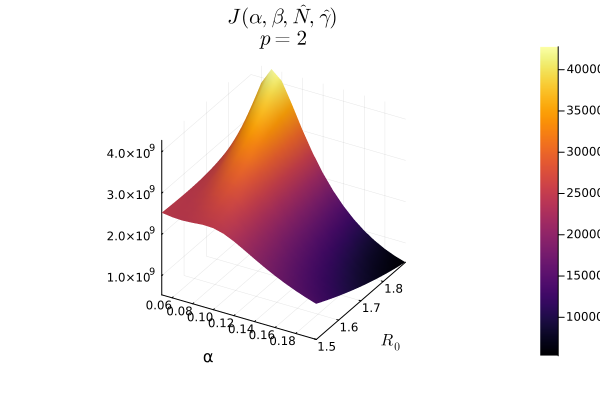

In [32]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot(x, x*y, 2), title=L"J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=2", xlabel="α", ylabel=L"R_{0}"))
png("p2surface_exercise1");

### 3)

In [33]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

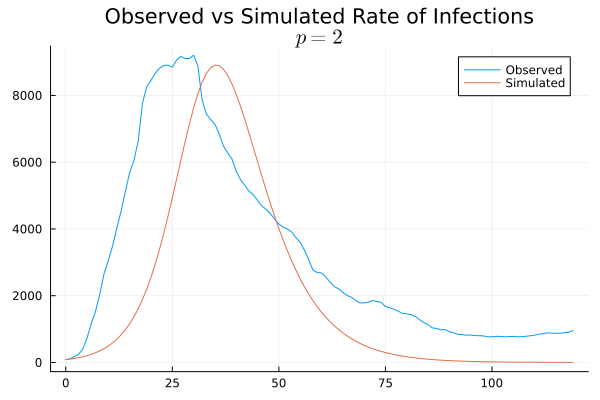

In [34]:
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "Observed vs Simulated Rate of Infections" * "\n" * L"p=2")

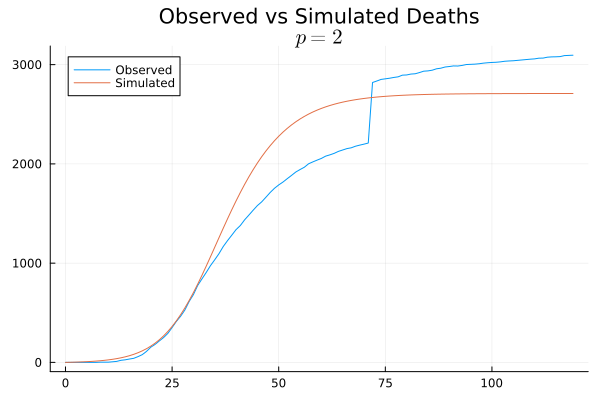

In [35]:
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "Observed vs Simulated Deaths" * "\n" * L"p=2")

### $p=\infty$

In [36]:
function J2(γ, Is, Rs, p)::Float64
    λ = 1
    f1(t) = abs(I(t) - Is[t+1])
    f2(t) = abs(y_deaths[t+1] - γ*Rs[t+1])
    return maximum(f1, 0:119) + λ*maximum(f2, 0:119)
end

J2 (generic function with 1 method)

In [37]:
Jd = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [38]:
for α in 0.05:0.01:0.2
    for r0 in 1.5:0.1:1.9
        for nn in 2:0.5:10
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N)
            γ̂  = optGammapinf(Rs, Y)
            Jd[(α, β, r0, N, γ̂)] = J2(γ̂, Is, Rs, 2)
        end
    end
end

In [39]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd)
J_min = Jd[argmin(Jd)];

In [40]:
display(L"\text{For}  p=∞")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=∞$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.2, 0.38, 1.9, 81435.3, 0.042497751265925136)


L"$J_{min}\approx 6431.479$"

In [41]:
81435/popu

0.04999981580469404

In [42]:
function Jplot2(α, β, p)
    S, I, R = euler(α, β, N̂)
    return J2(γ̂, I, R, p)
end

Jplot2 (generic function with 1 method)

### 2)

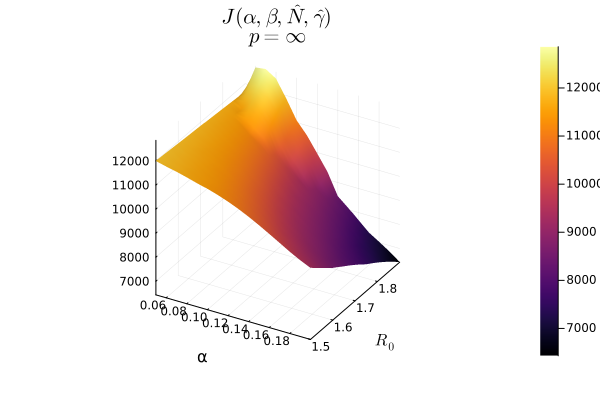

In [43]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot2(x, x*y, 2), title=L"J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=∞", xlabel="α", ylabel=L"R_{0}"))
png("pinfsurface_exercise1");

### 3)

In [44]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

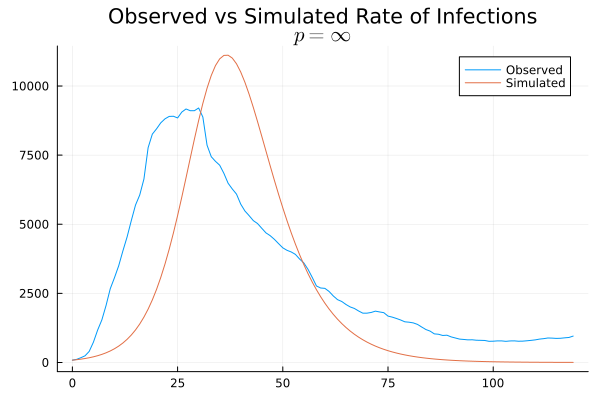

In [45]:
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "Observed vs Simulated Rate of Infections" * "\n" * L"p=∞")

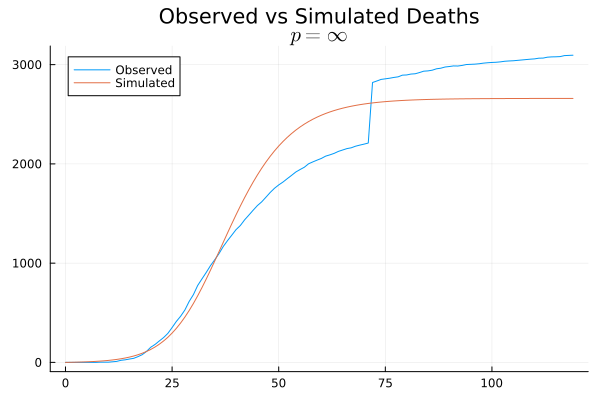

In [46]:
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "Observed vs Simulated Deaths" * "\n" * L"p=∞")

### 4)
We would increase the value of $\alpha$ to maybe $\alpha \in [0.2, 0.6]$ to start. Also, an increase in $\hat{N}$ seems to return simulated values closer to the observed ones, so we would start by establishing $\frac{N}{Population} \in [10\%, 20\%]$. For $R_{0}$ we would increase its value since for all values of $p$ we got $R_{0} = \sup[1.2, 1.9]$, a good place to start would be $R_{0} \in [1.9, 3]$

# Excercise 2

In [47]:
# euler method to compute S_sim, E_sim, I_sim, and R_sim
function euler(alpha, beta, delta, N)
    h = 0.01

    S_sim = zeros(tmax+1)
    E_sim = zeros(tmax+1)
    I_sim = zeros(tmax+1)
    R_sim = zeros(tmax+1)
  
    s = N
    e = I(0)
    i = I(0)
    r = 0
  
    t = 0
    while t < tmax + 0.0001
      if abs(round(Int, t) - t) < 0.0001
        S_sim[round(Int, t)+1] = s 
        E_sim[round(Int, t)+1] = e
        I_sim[round(Int, t)+1] = i 
        R_sim[round(Int, t)+1] = r 
      end
  
      ds = -beta*s*(i/N)
      de = beta*s*(i/N) - delta*e
      di = delta*e - alpha*i
      dr = alpha*i
    
      s += h*ds
      e += h*de
      i += h*di
      r += h*dr
      t += h
    end
  
    return S_sim, E_sim, I_sim, R_sim
  end

euler (generic function with 3 methods)

In [48]:
# objective function J
function J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    is_inf = false
    if p == 3
       is_inf = true
       p = 1
    end

    s1(t) = abs(I(t) - I_sim[t+1])^p
    s2(t) = abs(Y(t) - gamma*R_sim[t+1])^p

    if is_inf
        return maximum(s1.(0:tmax) + λ*s2.(0:tmax)) # two maximums sum
    else
        return sum(s1, 0:tmax) + λ*sum(s2, 0:tmax)
    end
end

J (generic function with 1 method)

In [49]:
min = [Inf, Inf, Inf]
minimizer = [(-1.0,-1.0,-1.0,-1.0,-1.0), (-1.0,-1.0,-1.0,-1.0,-1.0), (-1.0,-1.0,-1.0,-1.0,-1.0)]

mind = [Dict(), Dict(), Dict()]
nn = Dict{Int64, Function}(1 => optGammap1, 2 => optGammap2, 3 => optGammapinf)

# run the euler method for each combination of parameters and find the minimizer and min of the objective function
for alpha in 0.05:0.05:0.4
    for beta in (1.5:0.1:1.9)*alpha
        for delta in 0.05:0.05:0.4
            for N in (2:10)*(population/100)
                I_sim, R_sim = euler(alpha, beta, delta, N)[3:4] 

                for p in 1:3
                    gamma = nn[p](R_sim, Y)
                    mind[p][(alpha, beta, delta, N, gamma)] = J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
                end
            end
        end
    end
end




In [50]:
for p in 1:3
    minimizer[p] = argmin(mind[p])
    min[p] = mind[p][minimizer[p]]
end

## (1)

In [51]:
display_p = ["1", "2", "∞"]

# print out the min and minimizer for each value of p
for p in 1:3
    println("p = " * display_p[p] * ":")
    println("minimum of J(alpha, beta, delta, N, gamma) = $(min[p])")
    println("alpha = $(minimizer[p][1]), beta = $(minimizer[p][2]), delta = $(minimizer[p][3]), N = $(minimizer[p][4]), gamma = $(minimizer[p][5])")
    println("")
end

p = 1:
minimum of J(alpha, beta, delta, N, gamma) = 240107.84793462453
alpha = 0.35, beta = 0.6649999999999999, delta = 0.4, N = 81435.3, gamma = 0.04696363166542318

p = 2:
minimum of J(alpha, beta, delta, N, gamma) = 8.278247653300321e8
alpha = 0.4, beta = 0.76, delta = 0.4, N = 97722.36, gamma = 0.036569733756936326

p = ∞:
minimum of J(alpha, beta, delta, N, gamma) = 7135.430012387385
alpha = 0.4, beta = 0.76, delta = 0.4, N = 162870.6, gamma = 0.021501287355507076



In [52]:
for x in [97722, 162870]
    @show x/popu
end

x / popu = 0.05999977896563284
x / popu = 0.09999963160938807


## (2)

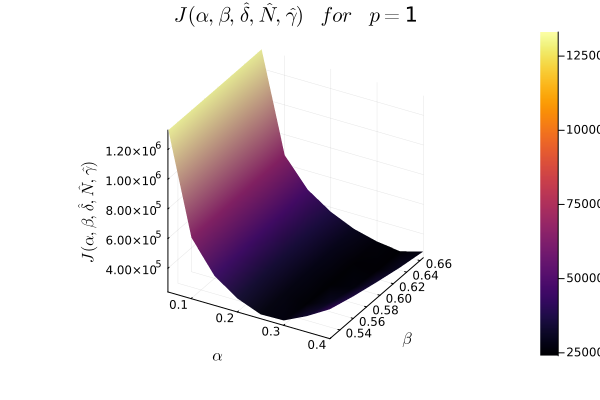

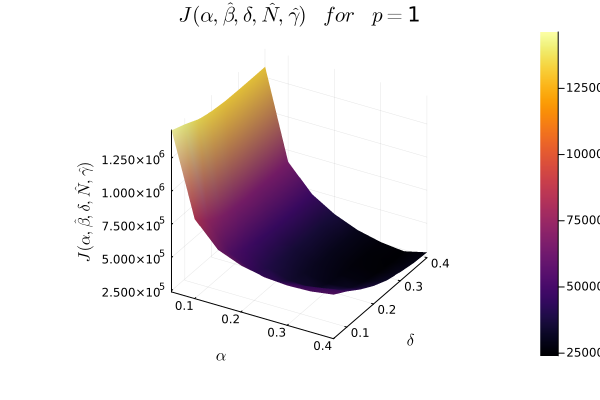

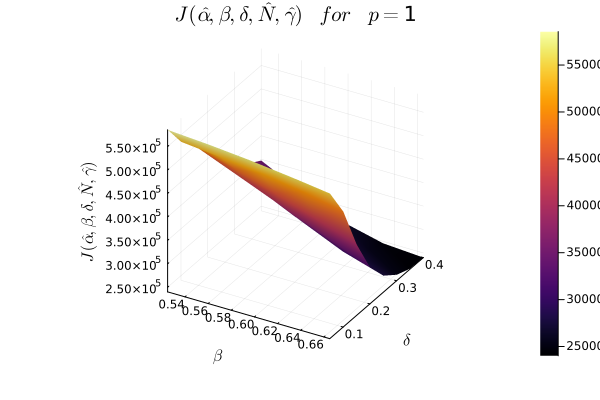

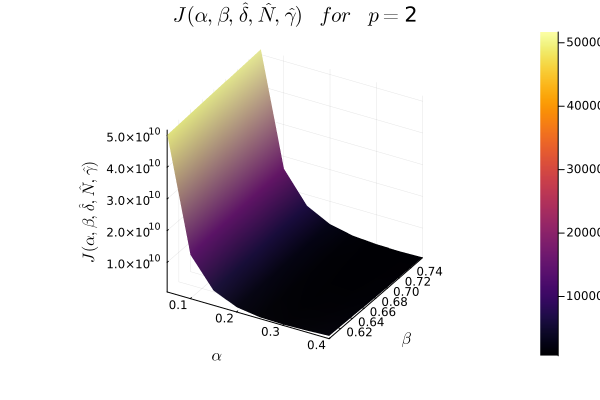

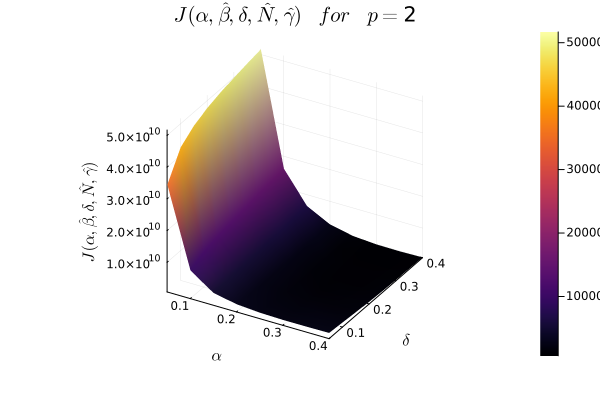

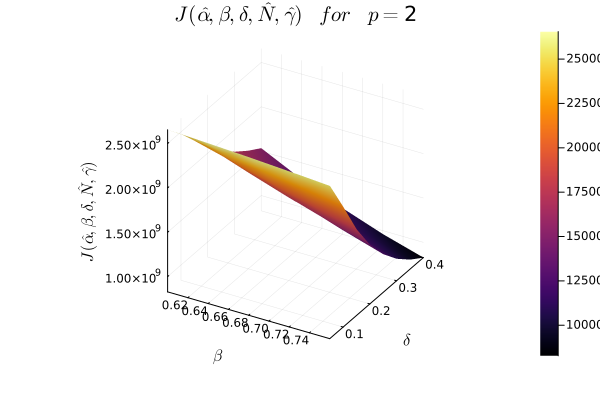

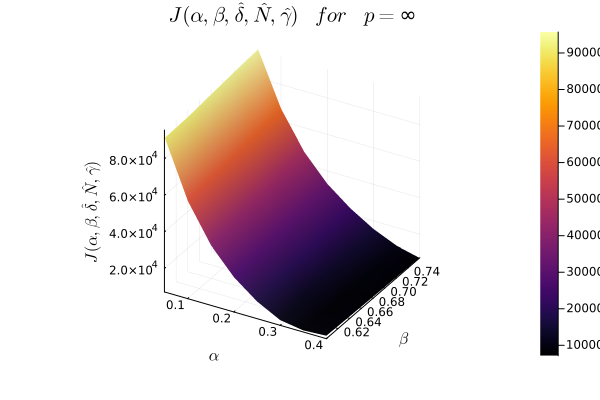

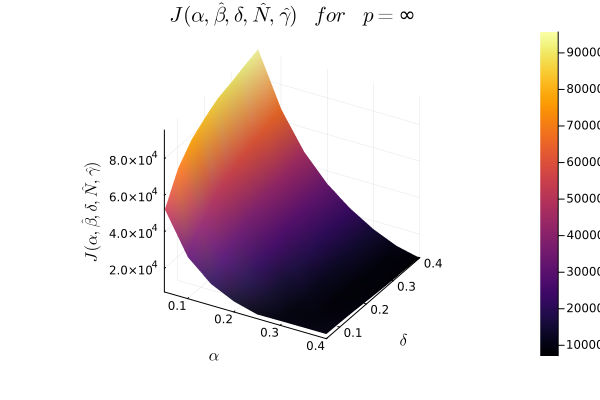

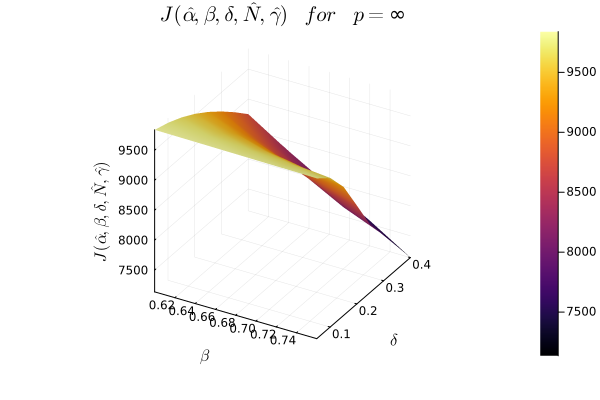

In [53]:
# make the 3 graphs of cross sections of J for each p
nnn = 1
for p in 1:3
    alpha, beta, delta, N, gamma = minimizer[p]

    function f_plot1(alpha, beta)
        S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)
        return J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    end
    display(surface(0.05:0.05:0.4, (1.5:0.1:1.9)*alpha, f_plot1, label = ["alpha" "beta" "J(alpha, beta, N, delta, gamma)"], title = L"J(\alpha, \beta, \hat{\delta}, \hat{N}, \hat{\gamma}) \quad for \quad p =" * display_p[p],
        zlabel=L"J(\alpha, \beta, \hat{\delta}, \hat{N}, \hat{\gamma})", xlabel=L"\alpha", ylabel=L"\beta"))
    png("exercise2_plot$(nnn)")
    nnn+=1

    function f_plot2(alpha, delta)
        S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)
        return J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    end
    display(surface(0.05:0.05:0.4, 0.05:0.05:0.4, f_plot2, label = ["alpha" "beta" "J(alpha, delta, N, delta, gamma)"], title = L"J(\alpha, \hat{\beta}, \delta, \hat{N}, \hat{\gamma}) \quad for \quad p =" * display_p[p],
        zlabel=L"J(\alpha, \hat{\beta}, \delta, \hat{N}, \hat{\gamma})", xlabel=L"\alpha", ylabel=L"\delta"))
    png("exercise2_plot$(nnn)")
    nnn+=1

    function f_plot3(beta, delta)
        S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)
        return J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    end
    display(surface((1.5:0.1:1.9)*alpha, 0.05:0.05:0.4, f_plot3, label = ["alpha" "beta" "J(alpha, delta, N, delta, gamma)"], title = L"J(\hat{\alpha}, \beta, \delta, \hat{N}, \hat{\gamma}) \quad for \quad p =" * display_p[p],
        zlabel=L"J(\hat{\alpha}, \beta, \delta, \hat{N}, \hat{\gamma})", xlabel=L"\beta", ylabel=L"\delta"))
    png("exercise2_plot$(nnn)")
    nnn+=1
end

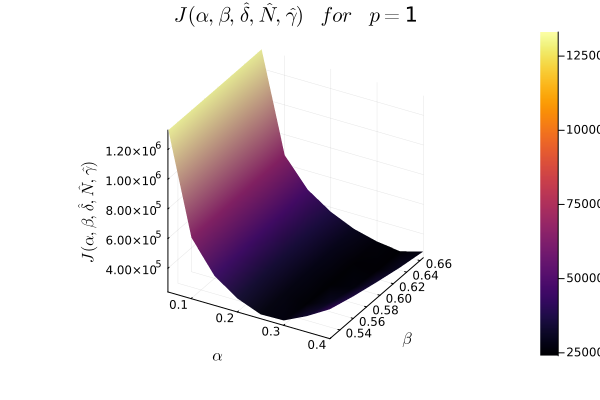

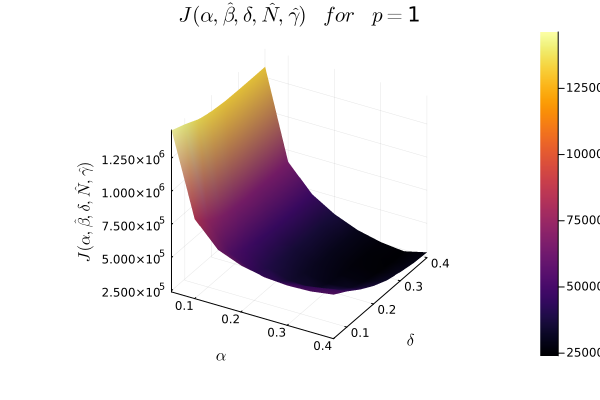

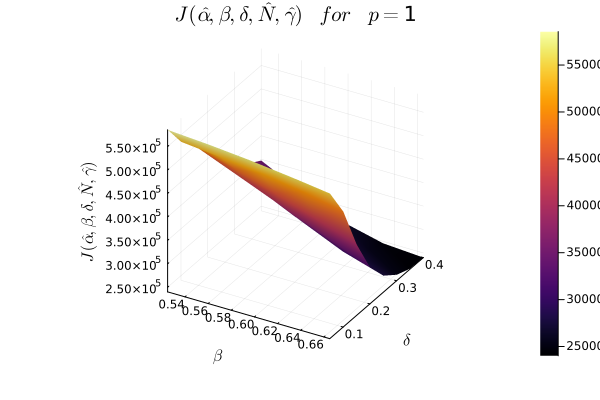

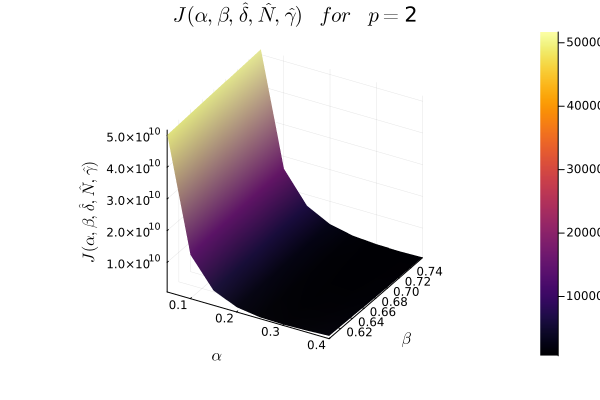

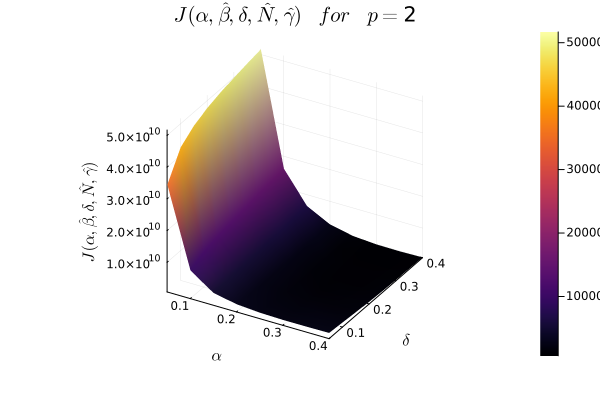

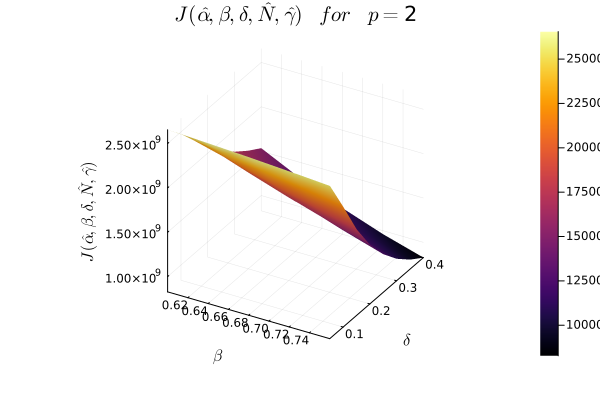

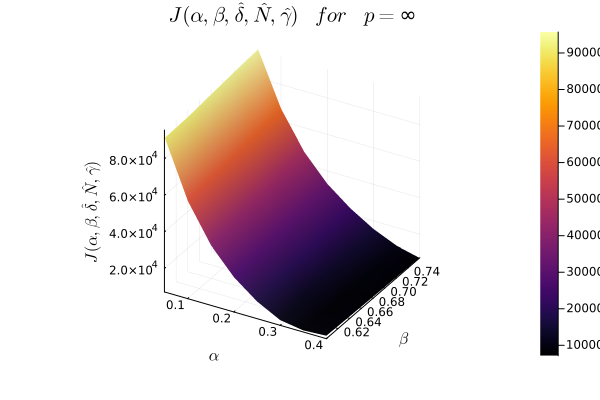

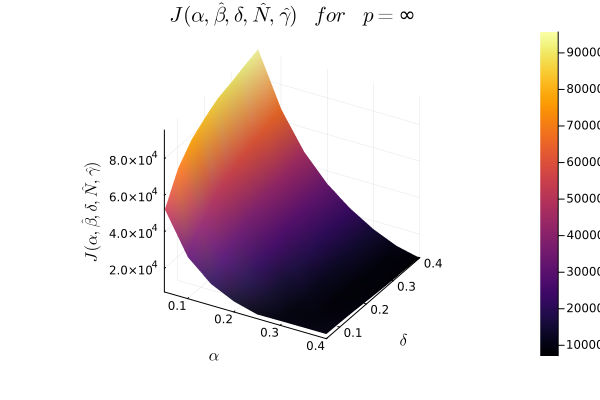

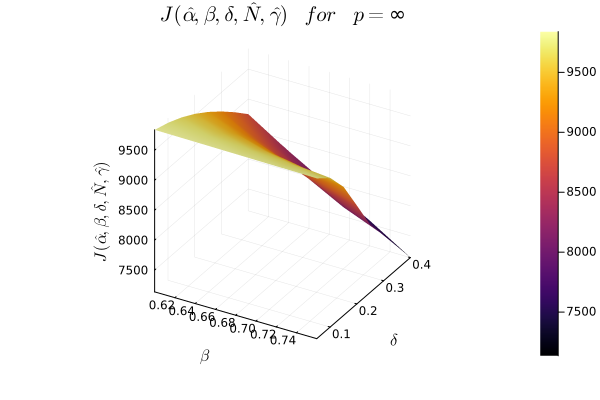

In [74]:
# make the 3 graphs of cross sections of J for each p
for p in 1:3
    alpha, beta, delta, N, gamma = minimizer[p]

    function f_plot1(alpha, beta)
        S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)
        return J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    end
    display(surface(0.05:0.05:0.4, (1.5:0.1:1.9)*alpha, f_plot1, label = ["alpha" "beta" "J(alpha, beta, N, delta, gamma)"], title = L"J(\alpha, \beta, \hat{\delta}, \hat{N}, \hat{\gamma}) \quad for \quad p =" * display_p[p],
        zlabel=L"J(\alpha, \beta, \hat{\delta}, \hat{N}, \hat{\gamma})", xlabel=L"\alpha", ylabel=L"\beta"))

    function f_plot2(alpha, delta)
        S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)
        return J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    end
    display(surface(0.05:0.05:0.4, 0.05:0.05:0.4, f_plot2, label = ["alpha" "beta" "J(alpha, delta, N, delta, gamma)"], title = L"J(\alpha, \hat{\beta}, \delta, \hat{N}, \hat{\gamma}) \quad for \quad p =" * display_p[p],
        zlabel=L"J(\alpha, \hat{\beta}, \delta, \hat{N}, \hat{\gamma})", xlabel=L"\alpha", ylabel=L"\delta"))

    function f_plot3(beta, delta)
        S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)
        return J(alpha, beta, delta, N, gamma, p, I_sim, R_sim)
    end
    display(surface((1.5:0.1:1.9)*alpha, 0.05:0.05:0.4, f_plot3, label = ["alpha" "beta" "J(alpha, delta, N, delta, gamma)"], title = L"J(\hat{\alpha}, \beta, \delta, \hat{N}, \hat{\gamma}) \quad for \quad p =" * display_p[p],
        zlabel=L"J(\hat{\alpha}, \beta, \delta, \hat{N}, \hat{\gamma})", xlabel=L"\beta", ylabel=L"\delta"))
end

## (3)

In [49]:
# plot I vs I_sim and Y vs gamma*R_sim
for p = 1:3
    alpha, beta, delta, N, gamma = minimizer[p]
    S_sim, E_sim, I_sim, R_sim = euler(alpha, beta, delta, N)

    display(plot(0:tmax, [I.(0:tmax), I_sim], label = ["Observed" "Simulated"], title="Rates of Active Infections for p = " * display_p[p], xlabel=L"t", ylabel=L"Rate \quad I(t)"))
    display(plot(0:tmax, [Y.(0:tmax), gamma*R_sim], label = ["Observed" "Simulated"], title="Cumulative Deaths for p = " * display_p[p], xlabel=L"t", ylabel=L"Y(t)"))
end

LoadError: UndefVarError: minimizer not defined

## (4)

In all of the objective fucntions with alpha the low values of alpha make the function very large and hard to tell what is happening in the low part. So narrowing in on the optimal alpha and seeing the effect delta and beta have in this reduced range would be good. For the graphs with beta and delta all three have there lowest point in the corner so it would be a good idea to increase the top of the range being searched for beta and delta. considering this some ranges to check would be alpha in [0.3, 0.4], R0 in [1.5, 3], delta in [0.05, 1], N/population in [2%, 10%].